# Lab 3
Danila Danko, Evgeny Panov

## 1. Motor simulation

### 1.1

In [667]:
import numpy as np
from scipy.integrate import solve_ivp

In [668]:
milli = 10 ** (-3)
kilo = 1 / milli
centi = 10 ** (-2)
rps = 2*np.pi/60
# value from sheet : SI value
mdata = {
    "nominal voltage, V": 12,
    "no load speed, rpm": 12100 * rps,
    "no load current, mA": 155 * milli,
    "nominal speed, rpm": 8040 * rps,
    "nominal torque, mNm": 10.2 * milli,
    "nominal current, A": 1.25,
    "stall torque, mNm": 31.3 * milli,
    "stall current, A": 3.47,
    "max. efficiency, %": 64 * centi,
    "terminal resistance, omega": 3.46,
    "terminal inductance, mH": 0.121 * milli,
    "torque constant, mNm/A": 9.02 * milli,
    "speed constant, rpm/V": 1 / (1060 * rps),
    "speed/torque gradient, rpm/mNm": 406 * rps / milli,
    "mechanical time constant, ms": 9.56 * milli,
    "rotor inertia, g*cm^2": 2.25 * milli * centi ** 2,
}

In [669]:
L = mdata["terminal inductance, mH"]
V = mdata["nominal voltage, V"]
K_b = mdata["speed constant, rpm/V"]
R = mdata["terminal resistance, omega"]
K_m = mdata["torque constant, mNm/A"]
J = mdata["rotor inertia, g*cm^2"]
tau_l = 0
B_m = 0

In [670]:
t1 = np.arange(
    start = 0, 
    stop = 100 * milli,
    step = 1 * milli * milli
)

In [671]:
x0 = [0, 0, 0]

In [672]:
def solve_motor(
    y0=x0, t_eval=t1, L=L, V=V, K_b=K_b, R=R, J=J, K_m=K_m, tau_l=tau_l, B_m=B_m
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t_eval` : `np.array`
          time coordinates
      `args` : `[float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `J` - rotor inertia
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient


    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    
    def state_space(t, y):
        return A.dot(y) + B

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [673]:
from utils import solve_list, plot_sol

In [674]:
sol = solve_list([[solve_motor,{"t_eval": t1}]])[0]

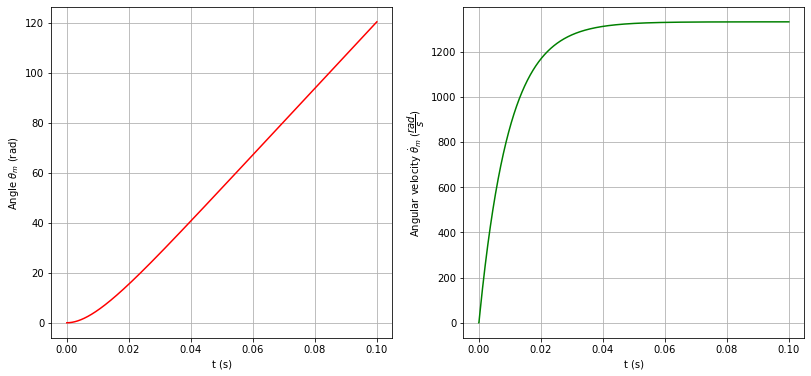

In [675]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

### 1.2

In [676]:
theta_dot = sol.y[2]
theta_dot_nl = theta_dot[-1]
print(f"No load speed (rpm):\n simulated: {theta_dot_nl / rps} \n theoretical: {mdata['no load speed, rpm'] / rps}")

No load speed (rpm):
 simulated: 12719.640010713814 
 theoretical: 12100.0


In [677]:
bound = 0.632 * np.abs(theta_dot_nl)
t_m_measured = sol.t[np.abs(theta_dot) <= bound][-1]

In [678]:
print(f"Time constant (ms):\n simulated: {t_m_measured / milli:0.7f} \n theoretical: {mdata['mechanical time constant, ms'] / milli:0.7f}")

Time constant (ms):
 simulated: 9.5760000 
 theoretical: 9.5600000


## 2. PD control

### 2.1

In [679]:
K_p=100
K_d=1
theta_d=100
theta_dot_d=0

In [680]:
voltage = []

def solve_motor_pd(
    y0=x0,
    t_eval=t1,
    L=L,
    V=V,
    K_b=K_b,
    R=R,
    J=J,
    K_m=K_m,
    tau_l=tau_l,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t_eval` : `np.array`
          time coordinates
      `args` : `[float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `J` - rotor inertia
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant
          `theta_d` - desired angle
          `theta_dot_d` - desired speed

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])

    def state_space(t, y):
        e = x_d - y[1:]
        u = K.dot(e)
        global voltage
        voltage += [[t, B.dot(u)[0] * L]]
        return A.dot(y) + B.dot(u)

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [681]:
sol = solve_list([[solve_motor_pd,{"t_eval": t1}]])[0]

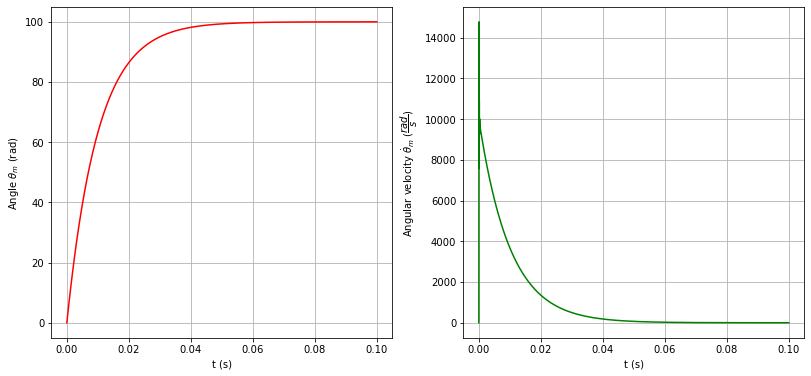

In [682]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

### 2.2

In [683]:
err_corridor = 2 * centi

def get_metrics(time, theta, theta_dot):
    bound = err_corridor * theta_d
    t_settling = time[np.abs(theta - theta_d) >= bound][-1]

    overs = theta[theta - theta_d >= 0.]
    overshoot = 0. if len(overs) == 0 else (np.amax(overs) - theta_d) / theta_d
    overshoot /= centi

    ss_error = np.abs(theta_d - theta[-1])

    max_speed = np.amax(theta_dot)

    return t_settling, overshoot, ss_error, max_speed

In [684]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[1], sol.y[2])

In [685]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 39.12799999999999
Overshoot (%): 0.0
Steady-state error (rad): 0.004544784066311536
Max speed (rpm): 141143.3169200812


### 2.3

In [686]:
voltage = np.array(voltage).T

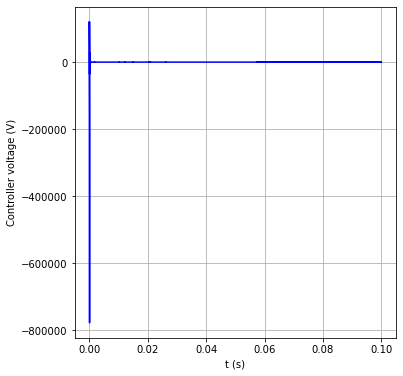

In [687]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Controller voltage (V)",
            "x": voltage[0],
            "graphs": [
                {"y": voltage[1], "color": "b"},
            ],
        },
    ]
)

### 2.4

In [688]:
def solve_motor_pd_saturated(
    y0=x0,
    t_eval=t1,
    L=L,
    V=V,
    K_b=K_b,
    R=R,
    J=J,
    K_m=K_m,
    tau_l=tau_l,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t_eval` : `np.array`
          time coordinates
      `args` : `[float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `J` - rotor inertia
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant
          `theta_d` - desired angle
          `theta_dot_d` - desired speed

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])

    def state_space(t, y):
        e = x_d - y[1:]
        u = K.dot(e)
        u = np.sign(u) * min(np.abs(u)/L, 1)
        return A.dot(y) + B.dot(u)

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [689]:
sol = solve_list([[solve_motor_pd_saturated,{"t_eval": t1}]])[0]

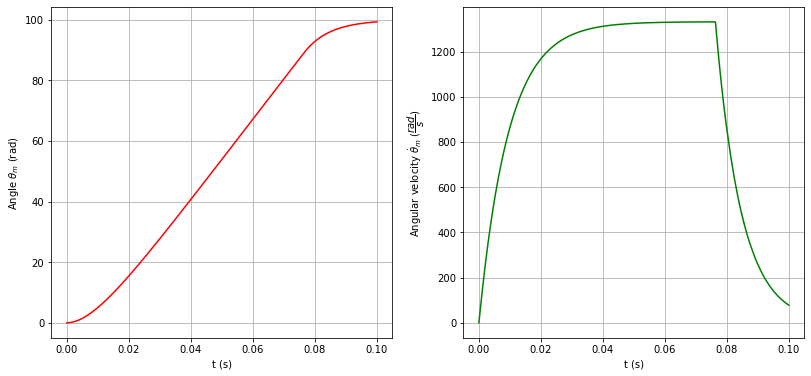

In [690]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

In [691]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[1], sol.y[2])

In [692]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 90.598
Overshoot (%): 0.0
Steady-state error (rad): 0.6472579309401283
Max speed (rpm): 12715.697422085166


## 3. Current-controlled motor

### 3.1

In [693]:
x0 = np.array([0,0])

In [694]:
def solve_motor_current_control(
    y0=x0,
    t_eval=t1,
    J=J,
    K_m=K_m,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t_eval` : `np.array`
          time coordinates
      `args` : `[float]`
          `J` - rotor inertia
          `K_m` - torque constant
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant
          `theta_d` - desired angle
          `theta_dot_d` - desired speed

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])

    def state_space(t, y):
        e = x_d - y
        u = K.dot(e)
        return np.array([y[1], 1/J * (K_m * u - B_m * y[1])])

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [695]:
sol = solve_list([[solve_motor_current_control,{"t_eval": t1}]])[0]

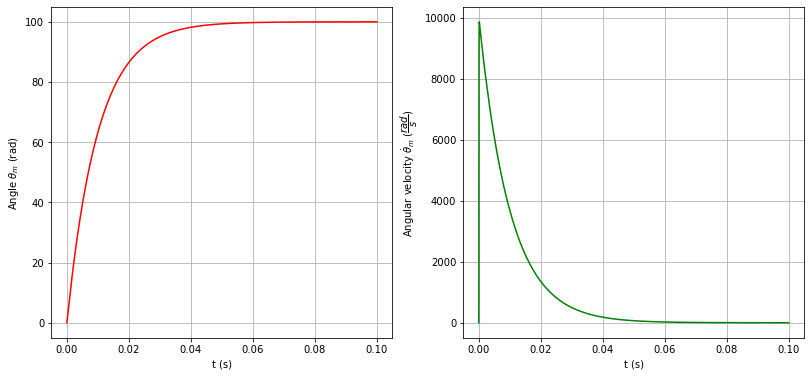

In [696]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[0], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "g"},
            ],
        },
    ]
)

In [697]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[0], sol.y[1])

In [698]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 39.047
Overshoot (%): 0.0
Steady-state error (rad): 0.0044387150953042465
Max speed (rpm): 94308.82693343573


### 3.2

In [709]:
x0 = np.array([0,0])

In [740]:
def solve_motor_current_control(
    y0=x0,
    t_eval=t1,
    J=J,
    K_m=K_m,
    B_m=B_m,
    K_p=K_p,
    K_d=K_d,
    theta_d=theta_d,
    theta_dot_d=theta_dot_d,
):
    """solver for current-controlled motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t_eval` : `np.array`
          time coordinates
      `args` : `[float]`
          `J` - rotor inertia
          `K_m` - torque constant
          `B_m` - friction coefficient
          `K_p` - proportional constant
          `K_d` - derivative constant
          `theta_d` - desired angle
          `theta_dot_d` - desired speed

    -------
    ### Returns
      `np.array`
          solution to the system
    """
    K = np.array([K_p, K_d])
    x_d = np.array([theta_d, theta_dot_d])
    stall_current = mdata["stall current, A"]

    def state_space(t, y):
        e = x_d - y
        u = K.dot(e)
        u = np.sign(u) * min(np.abs(u), stall_current)
        return np.array([y[1], 1/J * (K_m * u - B_m * y[1])])

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [741]:
sol = solve_list([[solve_motor_current_control,{"t_eval": t1}]])[0]

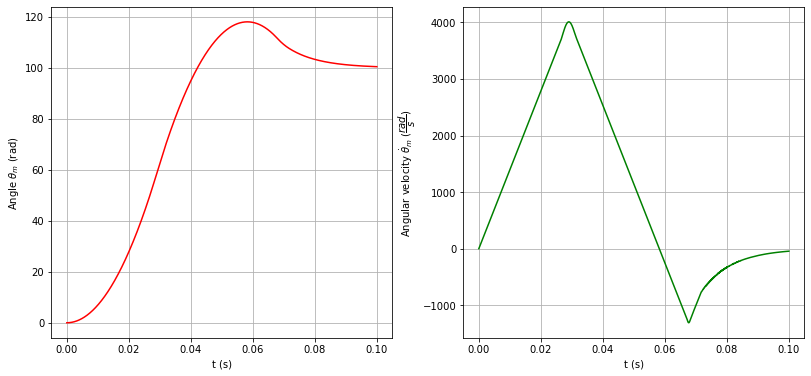

In [742]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[0], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "g"},
            ],
        },
    ]
)

In [743]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[0], sol.y[1])

In [744]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 85.048
Overshoot (%): 18.037399265311635
Steady-state error (rad): 0.4469295444462347
Max speed (rpm): 38295.994312801005


### 3.3

In [745]:
sol = solve_list([[solve_motor_current_control,{"t_eval": t1, "K_d": K_d * 1.4}]])[0]

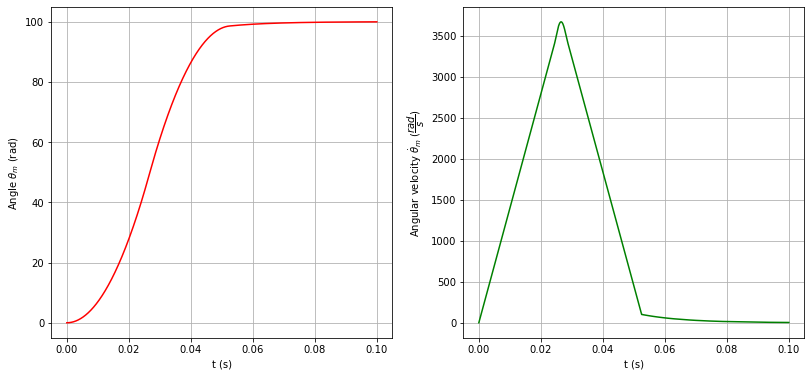

In [746]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[0], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "g"},
            ],
        },
    ]
)

In [747]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[0], sol.y[1])

In [748]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 50.257999999999996
Overshoot (%): 0.0
Steady-state error (rad): 0.04759289613183171
Max speed (rpm): 35023.600493472186


### 3.3 realistic

In [760]:
t2 = np.arange(
    start = 0, 
    stop = 600 * milli,
    step = 1 * milli * milli
)

In [769]:
sol = solve_list([[solve_motor_current_control,{"t_eval": t2, "K_d": K_d*10}]])[0]

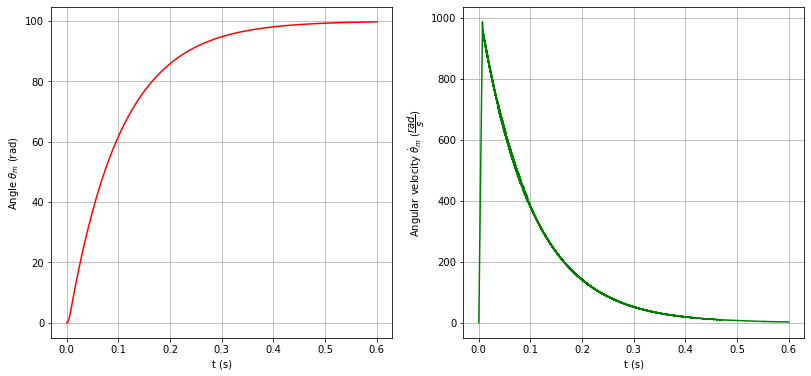

In [770]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[0], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[1], "color": "g"},
            ],
        },
    ]
)

In [771]:
t_settling, overshoot, ss_error, max_speed = get_metrics(sol.t, sol.y[0], sol.y[1])

In [772]:
print(f"Settling time (ms): {t_settling / milli}")
print(f"Overshoot (%): {overshoot}")
print(f"Steady-state error (rad): {ss_error}")
print(f"Max speed (rpm): {max_speed / rps}")

Settling time (ms): 395.405
Overshoot (%): 0.0
Steady-state error (rad): 0.2584962741041892
Max speed (rpm): 9423.95189609003
